# EVM Memory Analysis: Usage Trends, and Pricing

## Abstract
Memory is a critical resource that enables complex computations within the Ethereum Virtual Machine (EVM). The cost of using memory, designed to prevent its abuse, has not been revised since the inception of Ethereum. However, efficiency gains from hardware advancements and client code optimizations warrants periodic repricing of this cost. By revising the pricing structure, it may be possible to reduce the costs associated with memory-intensive operations in the EVM, thereby making previously prohibitively expensive applications feasible.

## Introduction

The EVM's memory is a *word-addressed* byte array that stores its ephemeral state. Accessing memory incurs fees in a unit called gas.

Gas does not measure the direct cost of execution, but rather the computational effort required by a node's hardware to execute EVM instructions. Transactors pay for per unit gas at market value which ultimately determines the execution cost.

The goal of this project is to provide insights that could potentially lead to repricing memory access costs, making them more affordable. To support this analysis, the usage of memory-accessing instructions (listed in Appendix A) was first examined across **100,000 blocks (from 20,770,001 to 20,870,000)** on the Ethereum mainnet.

## Usage Trends
A total of **3,116,961,839** memory-accessing instructions were recorded.

### Memory size 

Certain instructions, such as `CALL`, may not require input from memory or may discard their return data instead of writing to memory. In these instances, a zero-length range of memory may be referenced, which [does not trigger an expansion](https://github.com/ethereum/yellowpaper/blob/9fde3f4a07487b702a4b30ff74f26e0cd153db05/Paper.tex#L2217) and incurs no gas cost. In total, **62,086,976** such instructions (**≈2%** of all memory-accessing instructions) were identified and excluded from further analysis.

Each instruction accesses between **1 byte and 48 KiB** of memory, with an average of **39 bytes** (slightly over 1 EVM word).

1000 5


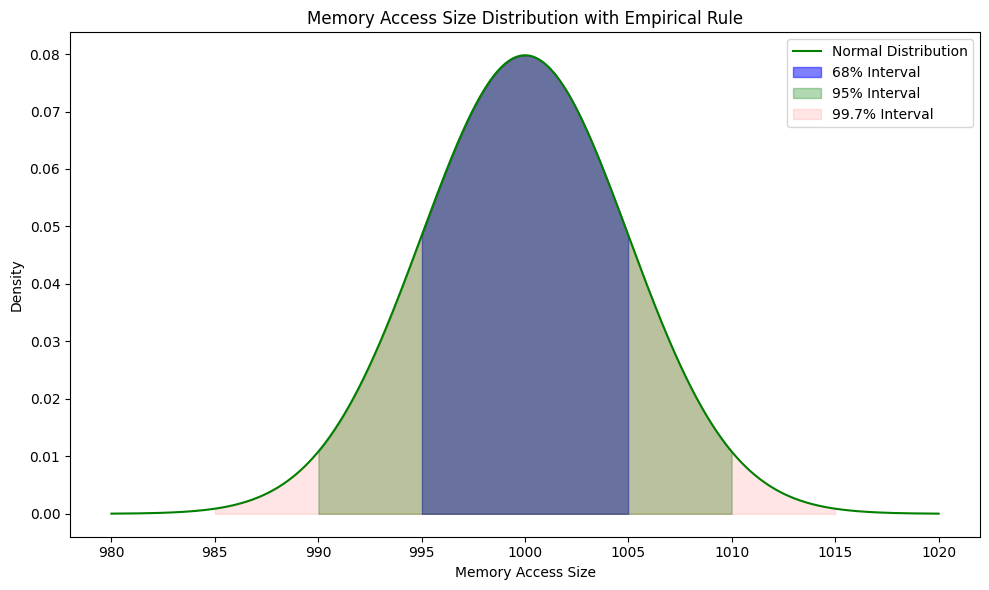

In [39]:
import vaex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# CONFIG
PERCENTILES = [25, 50, 75, 95, 99]
PRIMARY_COLOR = 'green'
PLOT_SIZE= (10, 6)

# Load the data
#df = vaex.open('data/combined_call_frames.hdf5')

# Calculate mean and standard deviation
mean = df['memory_access_size'].mean()
std_dev = df['memory_access_size'].std()


print(mean, std_dev)

# Prepare data for plotting
x = np.linspace(max(0, mean - 4*std_dev) , mean + 4*std_dev, 1000)
y = norm.pdf(x, mean, std_dev)

# Setup
plt.figure(figsize=PLOT_SIZE)
sns.lineplot(x=x, y=y, label=f"Normal Distribution", color=PRIMARY_COLOR)

# Highlight the empirical rule
plt.fill_between(x, y, where=((x >= mean - std_dev) & (x <= mean + std_dev)), color='blue', alpha=0.5, label='68% Interval')
plt.fill_between(x, y, where=((x >= mean - 2*std_dev) & (x <= mean + 2*std_dev)), color='green', alpha=0.3, label='95% Interval')
plt.fill_between(x, y, where=((x >= mean - 3*std_dev) & (x <= mean + 3*std_dev)), color='red', alpha=0.1, label='99.7% Interval')

# Percentile table
# percentile_values = [df['memory_access_size'].quantile(p/100).item() for p in PERCENTILES]
# table_data = [[f'{p}%' for p in percentiles], [f'{value:.2f}' for value in percentile_values]]
# table = plt.table(cellText=table_data,
#                   colLabels=['Percentile', 'Value'],
#                   cellLoc='center',
#                   loc='bottom',
#                   bbox=[0.2, -0.3, 0.6, 0.2])
# table.auto_set_font_size(False)
# table.set_fontsize(12)
# table.scale(1.5, 1.5)

# Plot
plt.title('Memory Access Size Distribution with Empirical Rule')
plt.xlabel('Memory Access Size')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Data description

In [13]:
df.describe()

,transaction_id,call_depth,opcode,memory_access_offset,memory_access_size,opcode_gas_cost,memory_expansion
data_type,large_string,int64,large_string,int64,int64,int64,int64
count,3054874863,3054874863,3054874863,3054874863,3054874863,3054874863,3054874863
NA,0,0,0,0,0,0,0
mean,--,2.887600998928381,--,1173.5257738346188,39.189048925700625,26355.779453277722,11.295759129757846
std,--,1.797839,--,8566.40178,160.459784,384223.091954,120.06417
min,--,1,--,0,1,0,0
max,--,34,--,1502656,460800,29506566,559328


## References

- 📄 Gavin W., [Ethereum Yellow Paper](https://ethereum.github.io/yellowpaper/paper.pdf)
- 📄 EPF Wiki, [EVM](https://epf.wiki/#/wiki/EL/evm)
- 📄 Eth Research, [On Block Sizes, Gas Limits and Scalability](https://ethresear.ch/t/on-block-sizes-gas-limits-and-scalability/18444)
- 📄 John A., [Wait, It's All Resource Pricing?](https://www.youtube.com/watch?v=YoWMLoeQGeI)
- 📄 John A., [Induced Demand from Blockchain Resource Pricing](https://www.youtube.com/watch?v=_6ctMrlhcO4)
- 📄 Martin H., [Gas benchmarks](https://github.com/ethereum/benchmarking/blob/master/constantinople/analysis2.md)
- 📜 Ipsilon, [EVM benchmarks](https://github.com/ipsilon/evm-benchmarks)
- 📄 Ethereum Research, [Gas Price Table](https://ethresear.ch/t/gas-price-table/67)
- 📄 Ipsilon et al., [EVM384 Update 5: First Gas Cost Estimates](https://notes.ethereum.org/@poemm/evm384-update5#Memory-Manipulation-Cost)
- 📜 Geth, [Protocol Params](https://github.com/ethereum/go-ethereum/blob/master/params/protocol_params.go)
- 📄 Eth Research,[EIP-1380: Reduced gas cost for call to self](https://ethereum-magicians.org/t/eip-1380-reduced-gas-cost-for-call-to-self/1242)
- 📄 Michael K., [A Scalable Method to Analyze Gas Costs, Loops and Related Security Vulnerabilities on the Ethereum Virtual Machine](https://raw.githubusercontent.com/wiki/usyd-blockchain/vandal/pubs/MKong17.pdf)

## Appendix A: Memory-accessing Instructions

| **Instruction** | **Description**                                                                                                            |
|-----------------|----------------------------------------------------------------------------------------------------------------------------|
| KECCAK256       | Compute Keccak-256 hash.                                                                                                   |
| CALLDATACOPY    | Copy input data in current environment to memory.                                                                          |
| CODECOPY        | Copy code running in current environment to memory.                                                                        |
| MLOAD           | Load word from memory.                                                                                                     |
| MSTORE          | Save word to memory.                                                                                                       |
| MSTORE8         | Save byte to memory.                                                                                                       |
| EXTCODECOPY     | Copy an account’s code to memory.                                                                                          |
| RETURNDATACOPY  | Copy output data from the previous call to memory.                                                                         |
| MCOPY           | Duplicate data in memory.                                                                                                  |
| LOG0            | Append log record with no topics.                                                                                          |
| LOG1            | Append log record with one topic.                                                                                          |
| LOG2            | Append log record with two topics.                                                                                         |
| LOG3            | Append log record with three topics.                                                                                       |
| LOG4            | Append log record with four topics.                                                                                        |
| CREATE          | Create a new account with associated code.                                                                                 |
| CALL            | Message-call into an account.                                                                                              |
| CALLCODE        | Message-call into this account with an alternative account’s code.                                                         |
| RETURN          | Halt execution returning output data.                                                                                      |
| DELEGATECALL    | Message-call into this account with an alternative account’s code, but persisting the current values for sender and value. |
| CREATE2         | Create a new deterministic account with associated code.                                                                   |
| STATICCALL      | Static message-call into an account.                                                                                       |